In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import cufflinks as cf
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as pl
import statsmodels.formula.api as sm
from scipy.interpolate import spline
%matplotlib inline

tls.set_credentials_file(username='jvani', api_key=os.getenv('PLOTLY_API'))

In [3]:
def cleanyears(row):
    datestring = str(row['Date'])
    datestring = datestring.lstrip('(+.c.,').rstrip(').').strip()
    if datestring[-4:].isdigit():
        datestring = datestring[-4:]
    elif datestring[-2:].isdigit() and datestring[-3] in ['-', '/']:
        datestring = datestring[-7:-5] + datestring[-2:]
    elif datestring[:4].isdigit():
        datestring = datestring[:4]
    else:
        datestring = 'UNCLEAR_DATE'
    if datestring != 'UNCLEAR_DATE' and int(datestring) < 1900:
        datestring = '-1899'
    return datestring

# Load data
artists = pd.read_csv('artists.csv')
artworks = pd.read_csv('artworks.csv').drop('Artist ID', axis=1)

# Clean artwork year data.
artworks = artworks[artworks['Acquisition Date'].apply(lambda x: type(x) == str)]
artworks['Acquisition Year'] = map(lambda x: x[:4], artworks['Acquisition Date'])
artworks['Date_Rev'] = artworks.apply(lambda row: cleanyears(row), axis=1)

# Merge artwork and artist data.
result = pd.merge(artworks, artists, how='inner', on=['Name'])

# Show source of UNCLEAR_DATE entries.
result[result['Date_Rev'] == 'UNCLEAR_DATE']['Date'].value_counts()[:5]

Unknown        829
n.d.           726
early 1940s    152
(n.d.)         126
early 1930s     97
Name: Date, dtype: int64

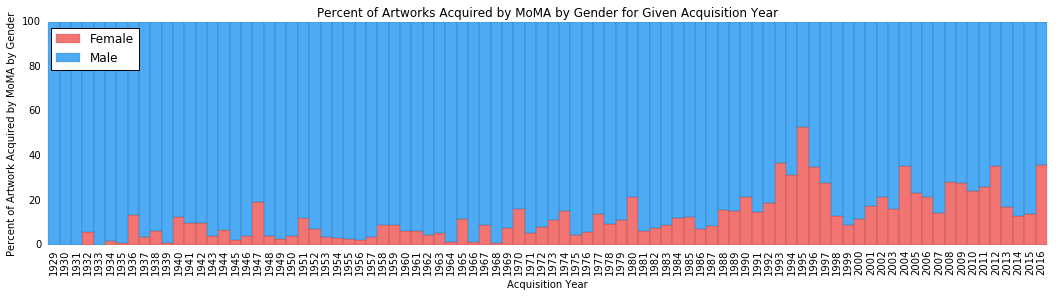

In [4]:
# Get gendered counts of artwork by acquisition year.
m_acq = result[result['Gender'] == 'Male'].groupby('Acquisition Year').size()
f_acq = result[result['Gender'] == 'Female'].groupby('Acquisition Year').size()

# Create gendered acquisition DataFrame.
gender_acq = pd.concat([m_acq, f_acq], axis=1).fillna(0)
gender_acq.columns = ['Male', 'Female']
gender_acq['Total'] = gender_acq.Male + gender_acq.Female
gender_acq['MalePercent'] = (gender_acq.Male / gender_acq.Total * 100).round(2)
gender_acq['FemalePercent'] = (gender_acq.Female / gender_acq.Total * 100).round(2)

# Plot figure.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(18, 4))
ax1.tick_params(top='off', bottom='off', left='off', right='off')
for spine in fig.gca().spines.values():
    spine.set_visible(False)
gender_acq[['FemalePercent', 'MalePercent']].plot(
    ax=ax1, kind='bar', stacked=True, width=1, alpha=0.8,
    color=['#EF5350', '#2196F3'], linewidth=0.15)
ax1.set_ylabel('Percent of Artwork Acquired by MoMA by Gender')
ax1.set_xlabel('Acquisition Year')
ax1.set_title('Percent of Artworks Acquired by MoMA by Gender for Given Acquisition Year')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, ['Female', 'Male'], loc=2)

In [10]:
f_text = ','.join('{}<br>{}'.format(*i) for i in zip(
        ['Percent: ' + str(i) + '%' for i in gender_acq.FemalePercent],
        ['Acquisitions: ' + str(int(i)) for i in gender_acq.Female])).split(',')
m_text = ','.join('{}<br>{}'.format(*i) for i in zip(
        ['Percent: ' + str(i) + '%' for i in gender_acq.MalePercent],
        ['Acquisitions: ' + str(int(i)) for i in gender_acq.Male])).split(',')

f = go.Bar(
    x=gender_acq.index,
    y=gender_acq.FemalePercent,
    name='Female Artists',
    marker=dict(color='#EF5350'),
    text=f_text,
    hoverinfo='x+text',
    opacity=0.8
)
m = go.Bar(
    x=gender_acq.index,
    y=gender_acq.MalePercent,
    name='Male Artists',
    marker=dict(color='#2196F3'),
    text=m_text,
    hoverinfo='x+text',
    opacity=0.8
)

data = [f, m]
layout = go.Layout(
    barmode='stack',
    title='Percent of MoMA Acquisitions by Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Percent of MoMA Acquisitions')
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='MOMA_Acquisition')

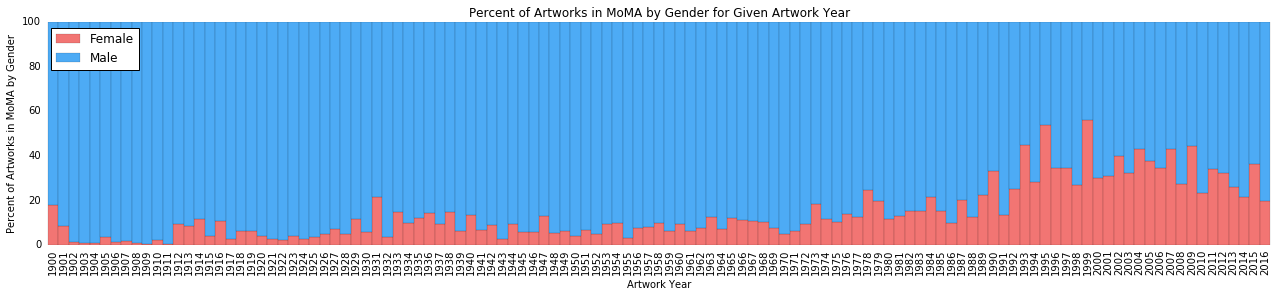

In [6]:
# Get gendered counts of artwork by year.
m_art = result[result['Gender'] == 'Male'].groupby('Date_Rev').size()
f_art = result[result['Gender'] == 'Female'].groupby('Date_Rev').size()

# Create gendered year DataFrame.
gender_art = pd.concat([m_art, f_art], axis=1).fillna(0)
gender_art.columns = ['Male', 'Female']
gender_art['Total'] = gender_art.Male + gender_art.Female
gender_art['MalePercent'] = (gender_art.Male / gender_art.Total * 100).round(2)
gender_art['FemalePercent'] = (gender_art.Female / gender_art.Total * 100).round(2)

# Query out some stuff.
gender_art = gender_art.loc[~gender_art.index.isin(['UNCLEAR_DATE', '-1899', '2017'])]

# Plot figure.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(22, 4))
ax1.tick_params(top='off', bottom='off', left='off', right='off')
for spine in fig.gca().spines.values():
    spine.set_visible(False)
gender_art[['FemalePercent', 'MalePercent']].plot(
    ax=ax1, kind='bar', stacked=True, width=1, alpha=0.8,
    color=['#EF5350', '#2196F3'], linewidth=0.15)
ax1.set_ylabel('Percent of Artworks in MoMA by Gender')
ax1.set_xlabel('Artwork Year')
ax1.set_title('Percent of Artworks in MoMA by Gender for Given Artwork Year')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, ['Female', 'Male'], loc=2)

In [13]:
f_text = ','.join('{}<br>{}'.format(*i) for i in zip(
        ['Percent: ' + str(i) + '%' for i in gender_art.FemalePercent],
        ['Artworks: ' + str(int(i)) for i in gender_art.Female])).split(',')
m_text = ','.join('{}<br>{}'.format(*i) for i in zip(
        ['Percent: ' + str(i) + '%' for i in gender_art.MalePercent],
        ['Artworks: ' + str(int(i)) for i in gender_art.Male])).split(',')

f = go.Bar(
    x=gender_art.index,
    y=gender_art.FemalePercent,
    name='Female Artists',
    marker=dict(color='#EF5350'),
    text=f_text,
    hoverinfo='x+text',
    opacity=0.8
)
m = go.Bar(
    x=gender_art.index,
    y=gender_art.MalePercent,
    name='Male Artists',
    marker=dict(color='#2196F3'),
    text=m_text,
    hoverinfo='x+text',
    opacity=0.8
)

data = [f, m]
layout = go.Layout(
    barmode='stack',
    title='Percent of MoMA Artwork by Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Percent of MoMA Artwork')  
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='MOMA_ArtYear')

In [8]:
gender_Lowry = gender_art.reset_index().rename(columns={'index': 'Year'})
gender_Lowry.Year = gender_Lowry.Year.astype('float64')
gender_Lowry = gender_Lowry[gender_Lowry.Year > 1994]

reg = sm.ols('FemalePercent ~ Year', data=gender_Lowry).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          FemalePercent   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     6.133
Date:                Thu, 16 Mar 2017   Prob (F-statistic):             0.0223
Time:                        14:29:13   Log-Likelihood:                -77.104
No. Observations:                  22   AIC:                             158.2
Df Residuals:                      20   BIC:                             160.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1444.1771    569.089      2.538      0.020       257.079  2631.275
Year          -0.7027      0.284     -2.477      0.022        -1.295    -0.111
==============================================================================
Omnibus:                        2.031   Durbin-Watson:                   2.777
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                1.438
Skew:                           0.411   Prob(JB):                        0.487
Kurtosis:                       2.056   Cond. No.                     6.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# Query out unclear years.
results = result.loc[~result.Date_Rev.isin(['UNCLEAR_DATE', '-1899', '2017'])].copy()
results.Date_Rev = results.Date_Rev.astype(int)
dec_90s = results[(results['Date_Rev'] > 1989) & (results['Date_Rev'] < 2000)].groupby('Gender').size()
dec_00s = results[(results['Date_Rev'] > 1999) & (results['Date_Rev'] < 2010)].groupby('Gender').size()
dec_10s = results[(results['Date_Rev'] > 2009) & (results['Date_Rev'] < 2020)].groupby('Gender').size()

def calcpercentwom(series):
    return float(series.Female) / sum(series) * 100

print 'Percent Women 90s: {} | Pieces: {} | Total: {}'.format(
    round(calcpercentwom(dec_90s), 2), dec_90s.Female, sum(dec_90s))
print 'Percent Women 00s: {} | Pieces: {} | Total: {}'.format(
    round(calcpercentwom(dec_00s), 2), dec_00s.Female, sum(dec_00s))
print 'Percent Women 10s: {} | Pieces: {} | Total: {}'.format(
    round(calcpercentwom(dec_10s), 2), dec_10s.Female, sum(dec_10s))

Percent Women 90s: 34.87 | Pieces: 2929 | Total: 8400
Percent Women 00s: 35.92 | Pieces: 3293 | Total: 9167
Percent Women 10s: 28.62 | Pieces: 595 | Total: 2079
